# Studying Furrowing using Facial Landmarks

In [56]:
import numpy as np
import os, json
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage.filters import gaussian_filter1d

In [57]:
dir = "E:/MASC/facial_data_analysis_videos"
songs = [5, 7, 8]
facial_landmarks2D = []
facial_landmarks3D = []
fpss = []

In [58]:
for i in songs:
    landmark2D =np.load("E:/MASC/facial_data_analysis_videos/{}/video/2D_mediapipe_landmark.npy".format(i))
    landmark3D =np.load("E:/MASC/facial_data_analysis_videos/{}/video/raw_mediapipe_landmark.npy".format(i))
    with open("E:/MASC/facial_data_analysis_videos/{}/video/other_info.json".format(i)) as json_file:
        data = json.load(json_file)
        fps = data["fps"]
    facial_landmarks2D.append(landmark2D)
    facial_landmarks3D.append(landmark3D)
    fpss.append(fps)

In [38]:
facial_landmarks3D[i].shape

(6051, 468, 3)

### Furrowing, Video 5

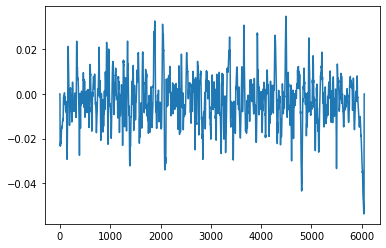

In [116]:
i = 0
# get the 3D landmarks
landmarks = facial_landmarks3D[i]
fps = fpss[i]
# get a mask to prevent data with zero values to bias the analysis
mask = np.sum(landmarks, axis=2).sum(axis=1, keepdims = True)
mask = np.where(mask==0, 0, 1)[:, 0]

# get the average horizontal distance between brows
# landmarks_mean = landmarks.mean(axis=0, keepdims=True)

landmarks_mean = gaussian_filter1d(landmarks, axis=0, sigma = int(50))


# compute horizontal distance
horizontal_distance = landmarks[:, 55, :] -  landmarks[:, 285, :]
horizontal_distance = np.linalg.norm(horizontal_distance, axis=1)
mean_distance = np.linalg.norm(landmarks_mean[:, 55, :] - landmarks[:, 285, :], axis=1)
# horizontal_distance = horizontal_distance - np.linalg.norm(landmarks_mean[0, 55] - landmarks_mean[0, 285])
horizontal_distance = (horizontal_distance - mean_distance)*mask
plt.plot(horizontal_distance)

6051


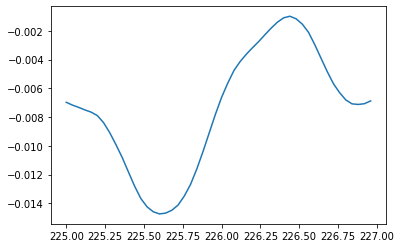

In [117]:
horizontal_distance_smoothed = savgol_filter(horizontal_distance, 13, 2)
start = 225
end = 227
ys = horizontal_distance_smoothed[(start)*25:(end)*25]
print(horizontal_distance_smoothed.shape[0])
xs = np.arange(start, end, step=1/(25))
plt.plot(xs, ys)

### Building Detection Model, Attempt 1

In [133]:
# I use a large window of smoothing to further smooth the signal, 
# this will not change the location of the peak
kernel_size = 6
kernel = np.ones(kernel_size) / kernel_size
horizontal_distance_smoothed2 = np.convolve(horizontal_distance_smoothed, kernel, mode='same')

# algorithm local variables
start_counter = -1
brow_furrow_interval = []
for i in range(3, horizontal_distance_smoothed2.shape[0]):
    val = horizontal_distance_smoothed2[i]
    if val < 0 and start_counter == -1:
        start_counter = i
    elif val > 0 and start_counter > 0:
        end_counter = i
        if (end_counter - start_counter) * 1/25 > 0.12:
            min_val = horizontal_distance_smoothed[start_counter:end_counter+1].min()
            if min_val <= -0.02:
                brow_furrow_interval.append([start_counter, end_counter])
        start_counter = -1
        

In [134]:
print(len(brow_furrow_interval))

21


In [137]:
for item in brow_furrow_interval:
    print(item[0]/25, "\t", item[1]/25)

0.12 	 6.24
14.8 	 18.36
32.16 	 35.92
37.88 	 38.56
49.32 	 50.2
54.52 	 57.12
62.96 	 65.36
82.92 	 84.56
106.96 	 107.76
112.32 	 115.88
123.36 	 124.56
126.96 	 128.88
129.84 	 132.68
135.52 	 139.84
154.8 	 156.72
172.24 	 176.8
181.96 	 187.56
191.04 	 193.28
201.84 	 204.04
204.4 	 206.84
219.36 	 220.36


### Building Detection Model, Attempt 2

In [167]:
# I use a large window of smoothing to further smooth the signal, 
# this will not change the location of the peak
kernel_size = 6
kernel = np.ones(kernel_size) / kernel_size
horizontal_distance_smoothed2 = np.convolve(horizontal_distance_smoothed, kernel, mode='same')

# algorithm local variables
start_counter = -1
brow_furrow_interval = []
for i in range(3, horizontal_distance_smoothed2.shape[0]):
    val = horizontal_distance_smoothed2[i]
    if val < 0 and start_counter == -1:
        start_counter = i
    elif val > 0 and start_counter > 0:
        end_counter = i
        if (end_counter - start_counter) * 1/25 > 0.12:
            min_area = horizontal_distance_smoothed[start_counter:end_counter+1].sum() / fps
            if min_area <= -(end_counter - start_counter) * 1/fps * 0.010 / 2 * 1.1:
                brow_furrow_interval.append([start_counter, end_counter])
        start_counter = -1
        

In [168]:
for item in brow_furrow_interval:
    print(item[0]/25, "\t", item[1]/25)

0.12 	 6.24
7.28 	 8.08
8.64 	 9.84
14.8 	 18.36
22.72 	 23.68
24.68 	 26.2
28.0 	 29.92
32.16 	 35.92
37.88 	 38.56
39.4 	 41.48
47.12 	 48.72
49.32 	 50.2
51.12 	 51.8
52.6 	 53.32
54.52 	 57.12
58.52 	 59.24
62.96 	 65.36
69.12 	 72.44
72.52 	 74.08
76.04 	 78.32
78.4 	 81.16
82.92 	 84.56
93.44 	 94.48
94.92 	 96.16
97.12 	 100.16
103.44 	 104.64
106.96 	 107.76
107.96 	 109.12
110.32 	 110.84
112.32 	 115.88
118.84 	 120.92
123.36 	 124.56
126.96 	 128.88
129.84 	 132.68
135.52 	 139.84
142.4 	 144.28
147.04 	 151.16
154.8 	 156.72
160.44 	 161.72
162.8 	 164.08
165.8 	 167.32
172.24 	 176.8
181.96 	 187.56
191.04 	 193.28
194.76 	 197.6
198.76 	 200.68
201.84 	 204.04
204.4 	 206.84
209.0 	 213.52
215.2 	 216.4
216.56 	 217.08
219.36 	 220.36
224.24 	 228.04
228.6 	 230.32
233.64 	 235.2


# Using regression on hand-labeled data

In [90]:
from util.sound_processing import *
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from sklearn.preprocessing import OneHotEncoder
import sklearn as sk

In [159]:
audio_1 = "E:/MASC/facial_data_analysis_videos/5/video.wav"
lyric_1 = "E:/MASC/facial_data_analysis_videos/5/video.txt"
audio_2 = "E:/MASC/facial_data_analysis_videos/7/video.wav"
lyric_2 = "E:/MASC/facial_data_analysis_videos/7/video.txt"

In [160]:
song2 = PraatScript_Lyric_Wrapper(audio_2, lyric_2)
song2.compute_self_phoneme_alignment()

C:\Users\evansamaa\anaconda3\envs\visemenet\lib\site-packages\torch\functional.py:471: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:664.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


['>', 'AH', 'N', 'D', '>', 'N', 'AW', '>', 'DH', 'AH', '>', 'EH', 'N', 'D', '>', 'IH', 'Z', '>', 'HH', 'IY', 'R', '>', 'AH', 'N', 'D', '>', 'S', 'OW', '>', 'AY', '>', 'F', 'EY', 'S', '>', 'DH', 'AE', 'T', '>', 'F', 'AY', 'N', 'AH', 'L', '>', 'K', 'ER', 'T', 'AH', 'N', '>', 'M', 'AY', '>', 'F', 'R', 'EH', 'N', 'D', '>', 'AY', 'L', '>', 'M', 'EY', 'K', '>', 'IH', 'T', '>', 'K', 'L', 'IH', 'R', '>', 'AY', 'L', '>', 'S', 'T', 'EY', 'T', '>', 'M', 'AY', '>', 'K', 'EY', 'S', '>', 'AH', 'V', '>', 'W', 'IH', 'CH', '>', 'AY', 'M', '>', 'S', 'ER', 'T', 'AH', 'N', '>', 'AY', 'V', '>', 'L', 'IH', 'V', 'D', '>', 'AH', '>', 'L', 'AY', 'F', '>', 'DH', 'AE', 'T', 'S', '>', 'F', 'UH', 'L', '>', 'AY', '>', 'T', 'R', 'AE', 'V', 'AH', 'L', 'D', '>', 'IY', 'CH', '>', 'AH', 'N', 'D', '>', 'EH', 'V', 'ER', 'IY', '>', 'HH', 'AY', 'W', 'EY', '>', 'AH', 'N', 'D', '>', 'M', 'AO', 'R', '>', 'M', 'AH', 'CH', '>', 'M', 'AO', 'R', '>', 'AY', '>', 'D', 'IH', 'D', '>', 'IH', 'T', '>', 'AY', '>', 'D', 'IH', 'D', '>', '

In [161]:
song2.write_textgrid("E:/MASC/facial_data_analysis_videos/7/", "video_aligned")

## After manually correcting the alignment, preparing dataset for linear regression

In [3]:
song1 = PraatScript_Lyric_Wrapper(audio_1, lyric_1, sentence_textgrids_path=["E:/MASC/facial_data_analysis_videos/5/video_aligned_fixed.TextGrid"])

In [5]:
song1.compute_self_pitch_intervals()

In [20]:
def smooth_signal(xs, ys):
    # return an interpolation object. 
    ys[ys == 0] = np.nan
    mask = np.isnan(ys)
    ys[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), ys[~mask])
    # use interpolation to deal with missing value in the pitch prediction
    ys = savgol_filter(ys, 21, 3)
    f = interp1d(xs, ys, kind="linear")
    return f

In [23]:
pitch_object = song1.pitch
pitch = pitch_object.selected_array['frequency']
intensity_object = song1.snd.to_intensity(time_step = song1.dt)
intensity = intensity_object.values[0].T
s_intensity = smooth_signal(pitch_object.xs(), pitch)
s_pitch = smooth_signal(intensity_object.xs(), intensity)

### get the categorical features

In [140]:
features = []
word_interval = song1.word_intervals
pitch_interval_temp = song1.pitch_intervals
pitch_interval = []
pitch_list_temp = song1.pitch_slopes
pitch_list =[]
for i in range(0, len(pitch_list_temp)):
    if len(pitch_list_temp[i]) == 0:
        pitch_interval.append(song1.phoneme_intervals[i])
        pitch_list.append(0)
    else:
        for j in range(0, len(pitch_list_temp[i])):
            pitch_interval.append(pitch_interval_temp[i][j])
            pitch_list.append(pitch_list_temp[i][j])
word_i = 0
pitch_interval_i = 0
interval_size = 0.15
time = song1.word_intervals[0][0]
while(time < song1.word_intervals[-1][1]):
    feature_t = []
    # check if word_i need to be updated
    if time <= word_interval[word_i][1] and time > word_interval[word_i][0]:
        pass
    elif time < word_interval[word_i][0]:
        for i in range(word_i, len(word_interval)):
            if time <= word_interval[i][1] and time > word_interval[i][0]:
                word_i = i
                break
    elif time > word_interval[word_i][1]:
        for i in range(word_i+1, len(word_interval)):
            if time <= word_interval[i][1] and time > word_interval[i][0]:
                word_i = i
                break
    percentile = (time - word_interval[word_i][0])/(word_interval[word_i][1] - word_interval[word_i][0])
    if percentile <= interval_size:
        feature_t.append("beginning")
    elif percentile > interval_size and percentile <= 1 - interval_size:
        feature_t.append("middle")
    else:
        feature_t.append("end")  
    
    if time <= pitch_interval[pitch_interval_i][1] and time > pitch_interval[pitch_interval_i][0]:
        pass
    elif time < pitch_interval[pitch_interval_i][0]:
        for i in range(pitch_interval_i, len(pitch_interval)):
            if time <= pitch_interval[i][1] and time > pitch_interval[i][0]:
                pitch_interval_i = i
                break
    elif time > pitch_interval[pitch_interval_i][1]:
        for i in range(pitch_interval_i+1, len(pitch_interval)):
            if time <= pitch_interval[i][1] and time > pitch_interval[i][0]:
                pitch_interval_i = i
                break
    slope = pitch_list[pitch_interval_i]
    if slope < 0:
        feature_t.append("drop")
    elif slope > 0:
        feature_t.append("raise")
    else:
        feature_t.append("held")
    time = time + 0.01
    features.append(feature_t)

In [141]:
enc = OneHotEncoder(handle_unknown='ignore')
x_feature = enc.fit_transform(features).toarray()
xs = np.arange(song1.word_intervals[0][0], song1.word_intervals[-1][1], 0.01)
pitch_feature = s_pitch(xs)
pitch_feature = (pitch_feature - pitch_feature.mean())/pitch_feature.std()
intensity_feature = s_intensity(xs)
pitch_feature = (intensity_feature - intensity_feature.mean())/intensity_feature.std()
# create the set of input features
input_feature = np.concatenate([x_feature, np.expand_dims(pitch_feature, 1), np.expand_dims(intensity_feature, 1)], axis=1)

In [112]:
features = []
word_position = []
word_interval = song1.word_intervals
pitch_interval_temp = song1.pitch_intervals
pitch_interval = []
pitch_list_temp = song1.pitch_slopes
pitch_list =[]
for i in range(0, len(pitch_list_temp)):
    if len(pitch_list_temp[i]) == 0:
        pitch_interval.append(song1.phoneme_intervals[i])
        pitch_list.append(0)
    else:
        for j in range(0, len(pitch_list_temp[i])):
            pitch_interval.append(pitch_interval_temp[i][j])
            pitch_list.append(pitch_list_temp[i][j])
word_i = 0
pitch_interval_i = 0
interval_size = 0.15
time = song1.word_intervals[0][0]
while(time < song1.word_intervals[-1][1]):
    feature_t = []
    # check if word_i need to be updated
    if time <= word_interval[word_i][1] and time > word_interval[word_i][0]:
        pass
    elif time < word_interval[word_i][0]:
        for i in range(word_i, len(word_interval)):
            if time <= word_interval[i][1] and time > word_interval[i][0]:
                word_i = i
                break
    elif time > word_interval[word_i][1]:
        for i in range(word_i+1, len(word_interval)):
            if time <= word_interval[i][1] and time > word_interval[i][0]:
                word_i = i
                break
    percentile = (time - word_interval[word_i][0])/(word_interval[word_i][1] - word_interval[word_i][0])
    word_position.append(percentile)
    if time <= pitch_interval[pitch_interval_i][1] and time > pitch_interval[pitch_interval_i][0]:
        pass
    elif time < pitch_interval[pitch_interval_i][0]:
        for i in range(pitch_interval_i, len(pitch_interval)):
            if time <= pitch_interval[i][1] and time > pitch_interval[i][0]:
                pitch_interval_i = i
                break
    elif time > pitch_interval[pitch_interval_i][1]:
        for i in range(pitch_interval_i+1, len(pitch_interval)):
            if time <= pitch_interval[i][1] and time > pitch_interval[i][0]:
                pitch_interval_i = i
                break
    slope = pitch_list[pitch_interval_i]
    if slope < 0:
        feature_t.append("drop")
    elif slope > 0:
        feature_t.append("raise")
    else:
        feature_t.append("held")
    time = time + 0.01
    features.append(feature_t)
enc = OneHotEncoder(handle_unknown='ignore')
x_feature = enc.fit_transform(features).toarray()
xs = np.arange(song1.word_intervals[0][0], song1.word_intervals[-1][1], 0.01)
pitch_feature = s_pitch(xs)
pitch_feature = (pitch_feature - pitch_feature.mean())/pitch_feature.std()
intensity_feature = s_intensity(xs)
pitch_feature = (intensity_feature - intensity_feature.mean())/intensity_feature.std()
# create the set of input features
input_feature = np.concatenate([x_feature, np.expand_dims(pitch_feature, 1), np.expand_dims(intensity_feature, 1), 
                               np.expand_dims(np.array(word_position), 1)], axis=1)

### Create the set of labels

In [142]:
target = []
with open("E:/MASC/facial_data_analysis_videos/5/brow_furrow_data.txt") as f:
    lines = f.readlines()

In [143]:
raw_output_features = []
for i in range(1, len(lines)):
    raw_feat_i = []
    current_line = lines[i]
    values = current_line.split(",")
    for v in range(0, len(values)-1):
        sec = values[v].split(".")[0]
        frame = values[v].split(".")[1]
        time = float(sec) + 1/25 * float(frame)
        raw_feat_i.append(time)
    raw_output_features.append(raw_feat_i)
raw_output_features = np.array(raw_output_features)
target_range = raw_output_features[:, 1:3]

target = []
time = song1.word_intervals[0][0]
cached_index = 0
while(time < song1.word_intervals[-1][1]):
    if time <= target_range[cached_index, 1] and time > target_range[cached_index, 0]:
        target.append(1)
    elif time < target_range[cached_index, 0]:
        target.append(0)
    elif time > target_range[cached_index, 1]:
        cached_index = min(cached_index + 1, target_range.shape[0]-1)
        if time <= target_range[cached_index, 1] and time > target_range[cached_index, 0]:
            target.append(1)
        else:
            target.append(1)
    time = time + 0.01
target = np.array(target)

In [144]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(input_feature, target, test_size=0.33)

In [158]:
reg = sk.linear_model.LinearRegression().fit(X_train, y_train)
pred = reg.predict(X_train)
pred_y = np.where(pred > 0.15, 1, 0)
print("number of positives in prediction: \t", pred_y.sum(),
      "\nnumber of positives in label: \t\t", y_train.sum())
print("train acc:", 1 - np.square(pred_y - y_train).mean())
pred = reg.predict(X_test)
pred_y = np.where(pred > 0.15, 1, 0)
print("number of positives in prediction: \t", pred_y.sum(),
      "\nnumber of positives in label: \t\t", y_test.sum())
print("test acc:", 1 - np.square(pred_y - y_test).mean())

number of positives in prediction: 	 158 
number of positives in label: 		 1510
train acc: 0.9021231554697715
number of positives in prediction: 	 76 
number of positives in label: 		 742
test acc: 0.8998988877654196


In [134]:
from matplotlib import pyplot as plt


1841 759
